In [1]:
!pip install pandas numpy scikit-learn scipy seaborn matplotlib phenograph umap-learn

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


# ACDC on the Bodenmiller dataset

Key infos on the dataset:
* Total samples: 16
* Paired replicates: 8 pairs (stimulated and reference conditions for each patient)
* 24 markers in total. Markers are classified as type markers (cell identity) or state markers (activation or signaling state).


Input to ACDC:

* FCS data: Flow or mass cytometry data files (e.g., PBMC8_30min_patient1_BCR-XL.fcs)
* Cell type-marker table: Specifies which markers define each cell type
* Metadata (to link samples, conditions, and patients)


Output from ACDC:

* Classified cell populations: Each cell is annotated with a cell type.
* Unknown populations: Cells that do not fit predefined markers.
* Visualizations such as:
1) UMAP or t-SNE plots of cell populations.
2) Heatmaps of marker expressions.
3) Comparison of cell frequencies between conditions.

In [85]:
import pandas as pd
import numpy as np 
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import phenograph
from sklearn.manifold import TSNE
import sys
sys.path.append('/dss/dsshome1/0F/di93quv/Systems_biomedicine/acdc/')
from ACDC.cell_type_annotation import *
import ACDC
import matplotlib as mpl
import matplotlib.patches as mpatches
%matplotlib inline 
import umap.umap_ as umap
from matplotlib import cm

In [114]:
# Load the data
path = '/dss/dsshome1/0F/di93quv/Systems_biomedicine/acdc/data/CyToF_data_Bodenmiller/csv_files/'
df = pd.read_csv(path + 'PBMC8_30min_patient1_Reference.csv', sep=',')
df

,Time,Cell_length,CD3,CD45,BC1(La139)Dd,BC2(Pr141)Dd,pNFkB,pp38,CD4,BC3(Nd146)Dd,...,pErk,BC6(Tm169)Dd,pLat,IgM,pS6,HLA-DR,BC7(Lu175)Dd,CD7,DNA-1(Ir191)Dd,DNA-2(Ir193)Dd
0,17866.0,34.0,33.450645,368.537630,-1.984764,-0.856689,34.581833,3.006462,-0.152802,1608.54460,...,-0.434349,-0.589500,0.268646,-0.499741,1.275597,-0.298759,19.900703,87.698944,284.022460,344.777830
1,23175.0,40.0,72.082570,1133.158400,25.422447,-0.626518,48.415480,23.147469,280.771940,2604.90100,...,3.842621,-0.729050,1.613319,-0.836624,-0.613892,1.225769,-0.850121,51.733720,149.259740,397.331570
2,25305.0,49.0,146.620970,1038.226800,-0.702469,-0.724564,19.931915,0.452751,493.999080,4097.82700,...,-0.249641,-0.061302,1.024643,-0.300179,-0.626198,2.991982,2.820671,68.328050,502.367000,1021.140600
3,28857.0,45.0,8.931084,839.623600,-2.212074,28.926376,125.469450,28.838943,63.852630,2271.56880,...,-0.613068,-0.617462,5.118538,-0.976608,3.638809,85.353930,1.674362,-0.158516,168.598880,547.375700
4,34799.0,28.0,67.459230,737.182700,-1.038177,-1.492920,-0.540077,-0.159828,79.619920,1550.82640,...,-0.654480,5.114235,-0.817932,-0.583321,0.101105,3.596123,4.625000,133.457000,238.022950,248.088710
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2734,430088.0,26.0,72.511140,458.630680,0.540466,0.051361,10.752716,6.196701,6.601143,1688.72450,...,0.972588,2.770241,-0.516533,-0.925995,-0.938316,7.472397,-0.453125,551.562600,303.577150,626.609130
2735,430201.0,53.0,7.110901,524.859900,7.782173,12.077171,3.143890,51.201935,12.665291,2340.72500,...,7.335564,1.913193,-0.301636,-0.478226,26.436104,7.066795,4.452522,714.613200,281.306980,461.616880
2736,441999.0,24.0,-1.482216,471.270140,-0.244095,-0.760269,2.472687,11.524239,1.045685,1242.06320,...,1.084984,-0.620811,-0.426323,8.738663,-0.520859,121.526750,-0.533737,-0.648697,177.386200,646.206100
2737,469277.0,49.0,-3.540672,328.661100,2.784470,4.441475,88.779740,7.515305,27.186287,2637.80370,...,0.810883,-0.855896,1.117836,3.177773,13.066284,143.866400,4.133484,1.518654,476.312070,692.975400


In [115]:
len(df.columns)

35

In [116]:
# Load your panel data
panel_data = pd.DataFrame({
    "fcs_colname": ["CD3(110:114)Dd", "CD45(In115)Dd", "pNFkB(Nd142)Dd", "pp38(Nd144)Dd", "CD4(Nd145)Dd",
                    "CD20(Sm147)Dd", "CD33(Nd148)Dd", "pStat5(Nd150)Dd", "CD123(Eu151)Dd", "pAkt(Sm152)Dd",
                    "pStat1(Eu153)Dd", "pSHP2(Sm154)Dd", "pZap70(Gd156)Dd", "pStat3(Gd158)Dd", "CD14(Gd160)Dd",
                    "pSlp76(Dy164)Dd", "pBtk(Er166)Dd", "pPlcg2(Er167)Dd", "pErk(Er168)Dd", "pLat(Er170)Dd",
                    "IgM(Yb171)Dd", "pS6(Yb172)Dd", "HLA-DR(Yb174)Dd", "CD7(Yb176)Dd"],
    "antigen": ["CD3", "CD45", "pNFkB", "pp38", "CD4", "CD20", "CD33", "pStat5", "CD123", "pAkt", 
                "pStat1", "pSHP2", "pZap70", "pStat3", "CD14", "pSlp76", "pBtk", "pPlcg2", "pErk", 
                "pLat", "IgM", "pS6", "HLA-DR", "CD7"],
    "marker_class": ["type", "type", "state", "state", "type", "type", "type", "state", "type", "state",
                     "state", "state", "state", "state", "type", "state", "state", "state", "state",
                     "state", "type", "state", "type", "type"]
})

# Load your main dataset
path = '/dss/dsshome1/0F/di93quv/Systems_biomedicine/acdc/data/CyToF_data_Bodenmiller/csv_files/'
df = pd.read_csv(path + 'PBMC8_30min_patient1_BCR-XL.csv', sep=',')

# Create a mapping dictionary from panel data
fcs_to_antigen = dict(zip(panel_data["fcs_colname"], panel_data["antigen"]))

# Rename columns in the dataset using the mapping dictionary
df = df.rename(columns=fcs_to_antigen)
df

,Time,Cell_length,CD3,CD45,BC1(La139)Dd,BC2(Pr141)Dd,pNFkB,pp38,CD4,BC3(Nd146)Dd,...,pErk,BC6(Tm169)Dd,pLat,IgM,pS6,HLA-DR,BC7(Lu175)Dd,CD7,DNA-1(Ir191)Dd,DNA-2(Ir193)Dd
0,33073.0,30.0,120.823265,454.60090,576.89830,10.005730,48.530518,2.882904,242.817320,11.514709,...,3.313606,-0.490013,39.422012,-0.587471,0.019905,-0.351120,119.41646,65.999830,268.22614,497.09980
1,36963.0,35.0,135.106170,624.68243,564.62994,5.599113,33.791183,-0.719887,353.723500,5.004433,...,-0.690170,0.287170,-0.269768,-0.223190,2.075256,1.609070,198.43066,355.431500,659.05084,763.47510
2,37892.0,30.0,-1.664619,601.01250,3077.26680,1.710579,-0.948380,3.589478,-0.386154,-0.601616,...,-0.996826,-0.277763,-0.811615,-0.342659,-0.409973,24.694168,1244.60080,106.664670,91.77101,318.51968
3,41345.0,58.0,115.290245,820.71246,6088.59670,22.564140,-0.829468,3.478378,58.075333,15.057991,...,22.598381,0.551300,-0.235779,-0.455894,0.212440,98.315094,2691.59570,21.070045,209.33554,451.79540
4,42475.0,35.0,14.373802,326.64053,4606.69300,-0.658485,-0.764381,-0.423012,-1.634590,-18.856384,...,-0.328339,-11.362267,3.564896,3.263878,-0.304131,13.282318,1241.02220,147.533200,115.99710,600.73710
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2833,430294.0,27.0,18.066742,341.67510,497.84308,25.796585,-0.017731,-0.198975,3.873932,2.436508,...,7.877380,-0.773956,1.853142,-0.575493,3.087067,3.941483,172.45493,142.018110,189.79874,396.09656
2834,433097.0,18.0,2.106224,123.96454,217.32520,0.298492,-0.938690,10.026894,60.297104,-0.019363,...,5.966072,-0.428711,-0.774803,-0.550423,-0.266640,-1.491463,98.54523,23.961891,176.82687,309.43597
2835,463881.0,41.0,62.944756,494.17650,369.46136,-2.874329,22.898918,-0.942383,181.150180,4.580536,...,-0.372803,-1.525993,12.151489,3.073914,-0.615654,0.456184,138.18332,201.638150,376.24698,376.13610
2836,471560.0,21.0,95.034070,616.17540,819.54140,2.464600,16.662110,7.933319,112.330260,4.577087,...,-0.993118,-0.424187,12.708961,0.473656,-0.514084,2.674141,435.99854,245.771420,289.62268,666.18730


In [117]:
# List of desired antigens
desired_antigens = ['LD', 'CD19', 'CD161', 'CD4', 'CD8', 'HLA-DR', 'CD14', 
                    'CD3', 'CD11c', 'CD69', 'CD56', 'CD16', 'VA72', 'GDTCR']

# Subset the DataFrame to keep only the desired columns
subset_columns = [col for col in desired_antigens if col in df.columns]
df = df[subset_columns]

df

,CD4,HLA-DR,CD14,CD3
0,242.817320,-0.351120,-0.539978,120.823265
1,353.723500,1.609070,-0.505928,135.106170
2,-0.386154,24.694168,-0.950508,-1.664619
3,58.075333,98.315094,-0.532700,115.290245
4,-1.634590,13.282318,-0.106133,14.373802
...,...,...,...,...
2833,3.873932,3.941483,12.027466,18.066742
2834,60.297104,-1.491463,-0.014252,2.106224
2835,181.150180,0.456184,-0.537544,62.944756
2836,112.330260,2.674141,-0.868332,95.034070


In [118]:
# List of columns based on df.columns
available_channels = ['CD4', 'HLA-DR', 'CD14', 'CD3']

# Apply the arc-sinh transformation to the available columns
df[available_channels] = np.arcsinh((df[available_channels].values - 1.0) / 5.0)
df

/tmp/ipykernel_2619559/4227545300.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[available_channels] = np.arcsinh((df[available_channels].values - 1.0) / 5.0)


,CD4,HLA-DR,CD14,CD3
0,4.571999,-0.267039,-0.303323,3.870162
1,4.949444,0.121515,-0.296808,3.982688
2,-0.273797,2.259889,-0.380829,-0.510464
3,3.129994,3.662323,-0.301931,3.822929
4,-0.505158,1.630940,-0.219461,1.710250
...,...,...,...,...
2833,0.547085,0.558763,1.531931,1.941639
2834,3.168043,-0.479684,-0.201484,0.219478
2835,4.277693,-0.108550,-0.302858,3.211577
2836,3.796714,0.328868,-0.365476,3.628073


In [119]:
#df['synthetic_label'] = 0  # Replace with actual label column if available

# Extract labels (y0)
#y0 = df['synthetic_label'].values

# Remove the label column to extract features
#df = df.drop('synthetic_label', axis=1)

# Extract features (X0)
X0 = df.to_numpy()

# Display the features and labels
print("Features (X0):", X0)
#print("Labels (y0):", y0)


Features (X0): [[ 4.5719987  -0.26703892 -0.30332296  3.87016216]
 [ 4.94944396  0.1215147  -0.29680847  3.98268841]
 [-0.27379713  2.25988939 -0.3808293  -0.51046431]
 ...
 [ 4.27769263 -0.10854982 -0.30285774  3.21157707]
 [ 3.79671425  0.32886799 -0.36547562  3.6280725 ]
 [-0.2748645   1.87133211 -0.29029196  0.07537265]]


In [120]:
X0.shape

(2838, 4)

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


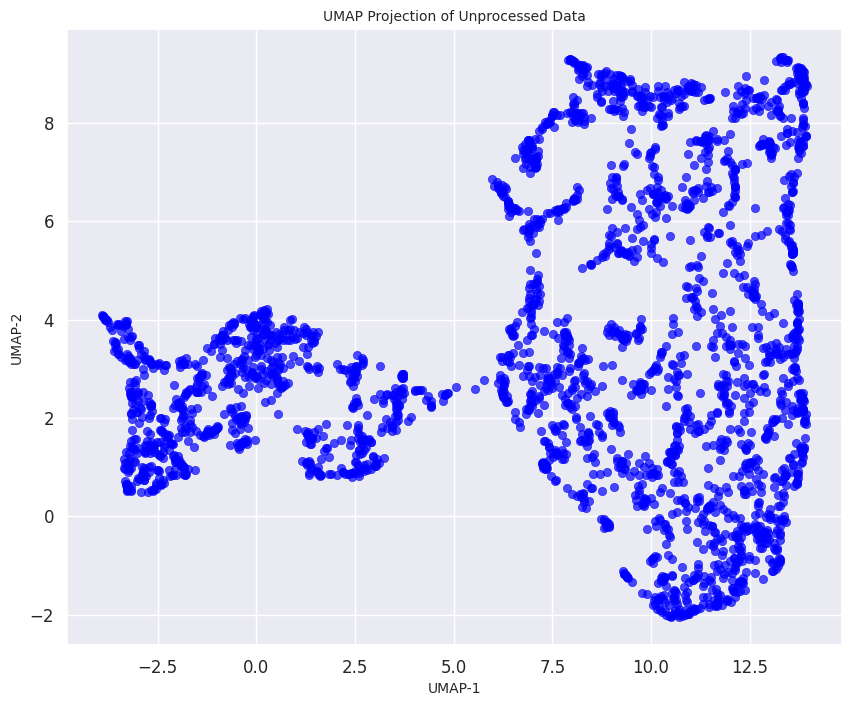

In [93]:
# Select columns with raw marker expressions for UMAP
raw_data = df[available_channels].to_numpy()  # Use the columns ['CD4', 'HLA-DR', 'CD14', 'CD3']

# Fit UMAP on raw data
umap_reducer = umap.UMAP(n_components=2, random_state=0)
Xre_raw = umap_reducer.fit_transform(raw_data)

# Plot the UMAP embedding
plt.figure(figsize=(10, 8))
sns.scatterplot(x=Xre_raw[:, 0], y=Xre_raw[:, 1], alpha=0.7, color="blue", edgecolor=None)
plt.title("UMAP Projection of Unprocessed Data", fontsize=10)
plt.xlabel("UMAP-1", fontsize=10)
plt.ylabel("UMAP-2", fontsize=10)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [121]:
# Read the cell type-marker table
csv_file = "../data/CyToF_data_Bodenmiller/ACDC_compatible_classification_matrix.csv"
table = pd.read_csv(csv_file)

# Set "Cell Type" as the index and drop it as a column
table = table.set_index('Cell Type')
table.index.name = None

# Save the reformatted table (optional)
table.to_csv("../data/reformatted_table.csv")

# Display the reformatted table
table

,LD,CD19,CD161,CD4,CD8,HLA-DR,CD14,CD3,CD11c,CD69,CD56,CD16,VA72,GDTCR
tote Zellen,1,0,0,0,0,0,0,0,0,0,0,0,0,0
B-Zellen,-1,1,0,-1,-1,0,-1,-1,0,0,0,0,0,0
Monozyten,-1,-1,0,-1,-1,0,1,-1,0,0,0,0,0,0
Mait-Zellen,-1,-1,1,0,0,0,-1,1,0,0,0,0,1,0
CD4 subpopulation: konventionelle CD4 Zellen,0,0,1,1,0,0,0,1,0,0,0,0,1,0
T-Helferzelle,-1,-1,0,1,-1,0,-1,1,0,0,0,0,0,0
cytotoxische T-Zelle,-1,-1,0,-1,1,0,-1,1,0,0,0,0,0,0
gd- T-Zellen,-1,-1,0,0,0,0,-1,1,0,0,0,0,0,1
NK-Zellen dim,-1,-1,0,0,0,0,-1,-1,0,0,1,0,0,0
NK-Zellen bright,-1,-1,0,0,0,0,-1,-1,0,0,1,0,0,0


In [122]:
# Subset the table to retain only the desired columns
table = table[['CD4', 'HLA-DR', 'CD14', 'CD3']]

# Display the subsetted table
table

,CD4,HLA-DR,CD14,CD3
tote Zellen,0,0,0,0
B-Zellen,-1,0,-1,-1
Monozyten,-1,0,1,-1
Mait-Zellen,0,0,-1,1
CD4 subpopulation: konventionelle CD4 Zellen,1,0,0,1
T-Helferzelle,1,0,-1,1
cytotoxische T-Zelle,-1,0,-1,1
gd- T-Zellen,0,0,-1,1
NK-Zellen dim,0,0,-1,-1
NK-Zellen bright,0,0,-1,-1


In [123]:
# Compute marker model
mk_model = compute_marker_model(df, table, 0.0)

In [124]:
mk_model

{'CD4': (array([0.91043342, 3.82635159]),
  array([0.52633554, 0.45528075]),
  array([0.4001954, 0.5998046])),
 'HLA-DR': (array([0.81865542, 2.35736352]),
  array([0.33673667, 1.16432155]),
  array([0.59605819, 0.40394181])),
 'CD14': (array([0.21288944, 1.50884947]),
  array([0.02258484, 0.71868066]),
  array([0.38871574, 0.61128426])),
 'CD3': (array([1.46517417, 3.13717246]),
  array([0.64096855, 0.38673825]),
  array([0.31623376, 0.68376624]))}

In [125]:
# Define helper dictionaries
idx2ct = [key for idx, key in enumerate(table.index)]
idx2ct.append('unknown')

ct2idx = {key: idx for idx, key in enumerate(table.index)}
ct2idx['unknown'] = len(table.index)

In [126]:
# Score computation
score0 = get_score_mat(X0, [], table, [], mk_model)
score0 = np.concatenate([score0, 1.0 - score0.max(axis=1)[:, np.newaxis]], axis=1)

In [127]:
# Compute unique index for clusters
thres = 0.5
ct_index0 = get_unique_index(X0, score0, table, thres)

In [128]:
# Average heatmap for cluster scores
ave_mat = []
for i, ct in enumerate(table.index):
    item = X0[ct_index0[:, i] == 1, :] if np.any(ct_index0[:, i] == 1) else X0[score0[:, i] > thres, :]
    ave_mat.append(np.mean(item, axis=0))
    
ave_mat = np.vstack(ave_mat)

In [129]:
# Manual gating average heatmap
#ct_mat = np.vstack([np.mean(X0[y0 == ct, :], axis=0) for ct in table.index])

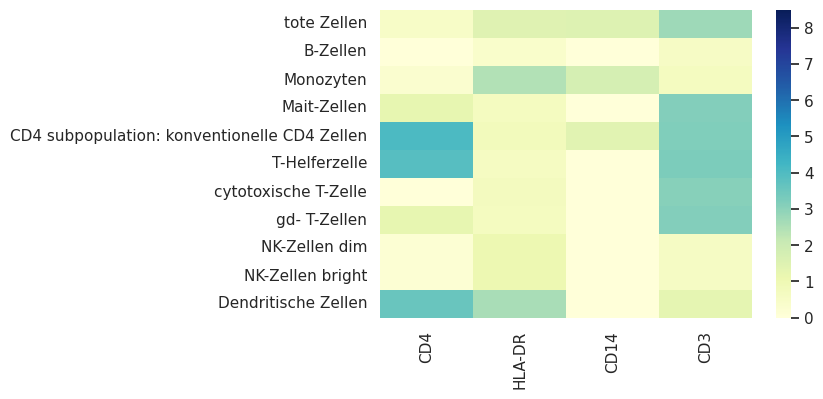

In [130]:
# Plotting heatmap
sns.set()
fig = plt.figure(figsize=(6, 4))
feature_mat_df = pd.DataFrame(ave_mat, columns=table.columns, index=table.index)
ax = sns.heatmap(feature_mat_df, vmin=0.0, vmax=8.5, cmap="YlGnBu")
plt.xticks(rotation=90)
plt.show()

In [131]:
# Compute landmarks and visualize
res_c = get_landmarks(X0, score0, ct_index0, idx2ct, phenograph, thres)
landmark_mat, landmark_label = output_feature_matrix(res_c, [idx2ct[i] for i in range(len(idx2ct))])

Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.021209716796875 seconds
Jaccard graph constructed in 1.0664210319519043 seconds
Wrote graph to binary file in 0.005396366119384766 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.341002
Louvain completed 21 runs in 0.18203520774841309 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 2.2679479122161865 seconds
Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.02415776252746582 seconds
Jaccard graph constructed in 1.2091155052185059 seconds
Wrote graph to binary file in 0.025411605834960938 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.758228
After 4 runs, maximum modularity is Q = 0.759611
After 14 runs, maximum modularity is Q = 0.760754
Louvain completed 34 runs in 0.8328118324279785 seconds
Sorting communities by size, please wait

In [132]:
X_plot = [landmark_mat.copy()]
y_plot = landmark_label[:]

for key in idx2ct:
    # Filter rows based on some condition related to 'key' in X0
    tmp = X0[:1000, :] if X0.shape[0] > 1000 else X0 
    y_plot += [key] * tmp.shape[0]  # Label for the current key
    X_plot.append(tmp)

X_plot = np.vstack(X_plot)
y_plot = np.array(y_plot)

# t-SNE transformation
tsne = TSNE(n_components=2, random_state=0)
Xre = tsne.fit_transform(X_plot)

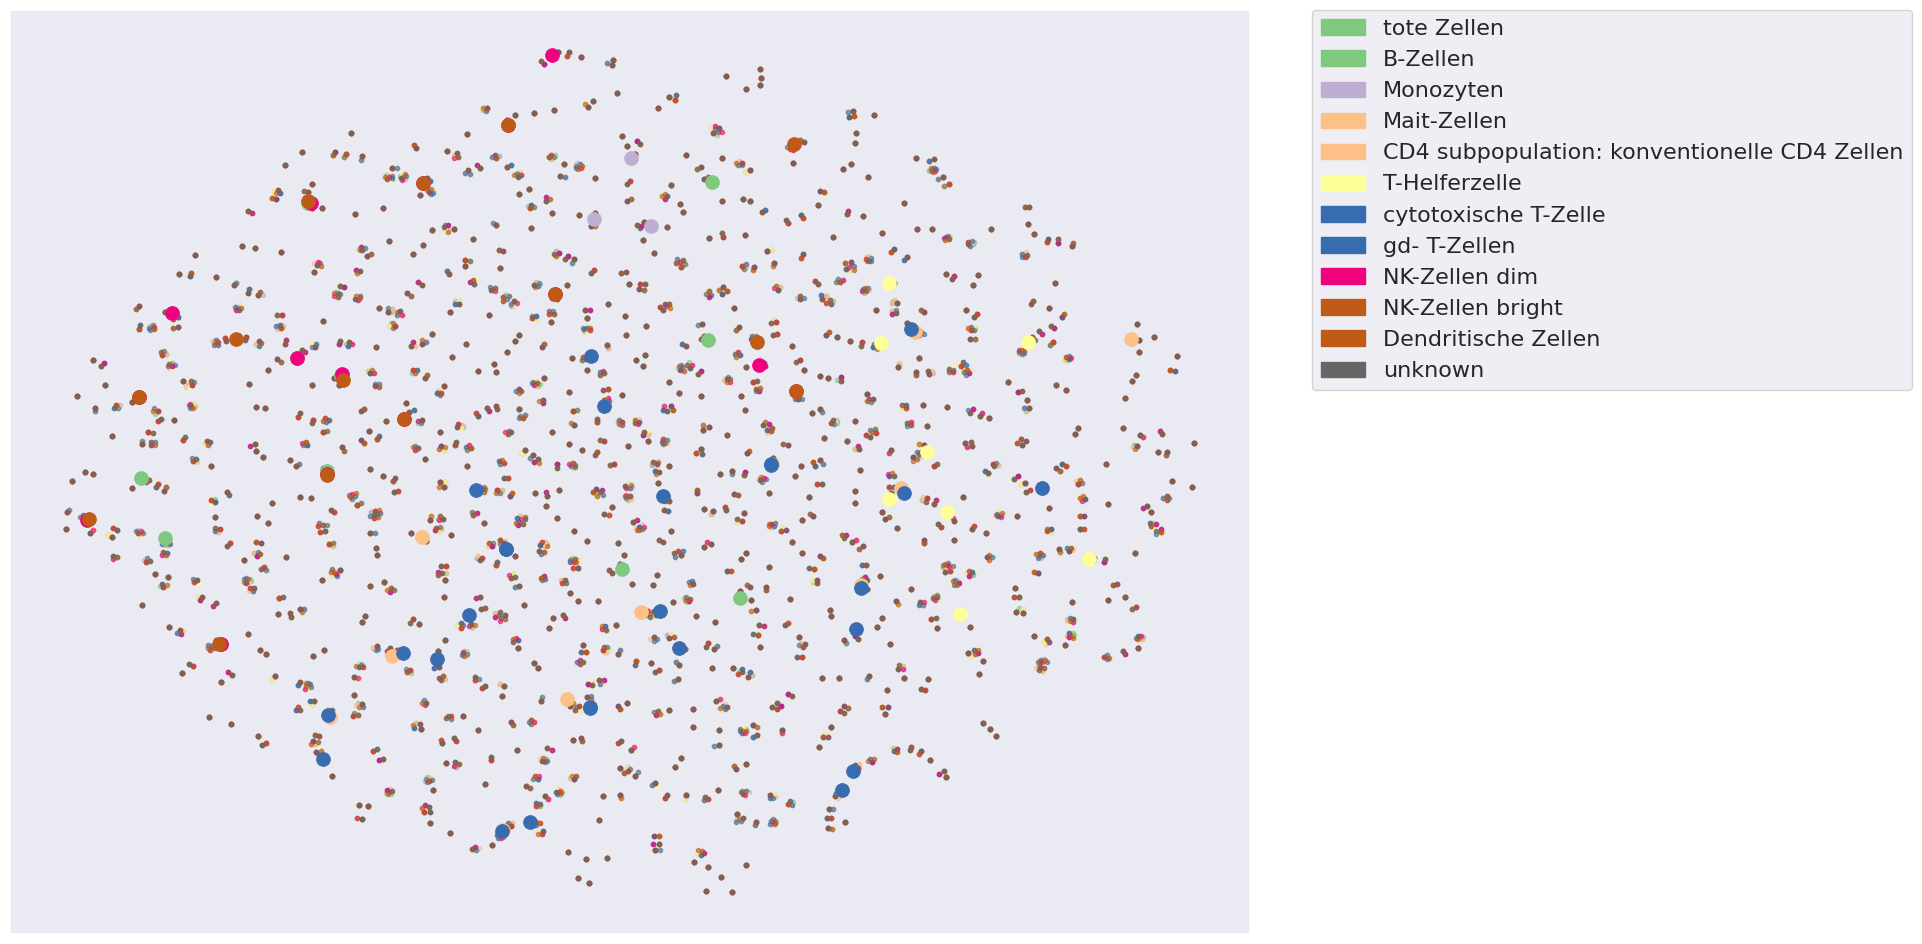

In [133]:
# Plotting t-SNE
cmap = plt.cm.Accent
fig = plt.figure(1, figsize=(16, 12))

for idx, key in enumerate(idx2ct):
    plt.plot(Xre[y_plot == key, 0], Xre[y_plot == key, 1], '.', color=cmap(idx / len(idx2ct)), alpha=0.6, label=key)

for idx, key in enumerate(landmark_label):
    ax, ay = Xre[idx, 0], Xre[idx, 1]
    plt.plot(ax, ay, 'o', color=cmap(ct2idx[key] / len(idx2ct)), alpha=1, markersize=10, markeredgewidth=0.5)

plt.legend(handles=[mpatches.Patch(color=cmap(idx / len(idx2ct)), label=key) for idx, key in enumerate(idx2ct)],
           bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., prop={'size': 16})

plt.xticks([])
plt.yticks([])
plt.show()

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


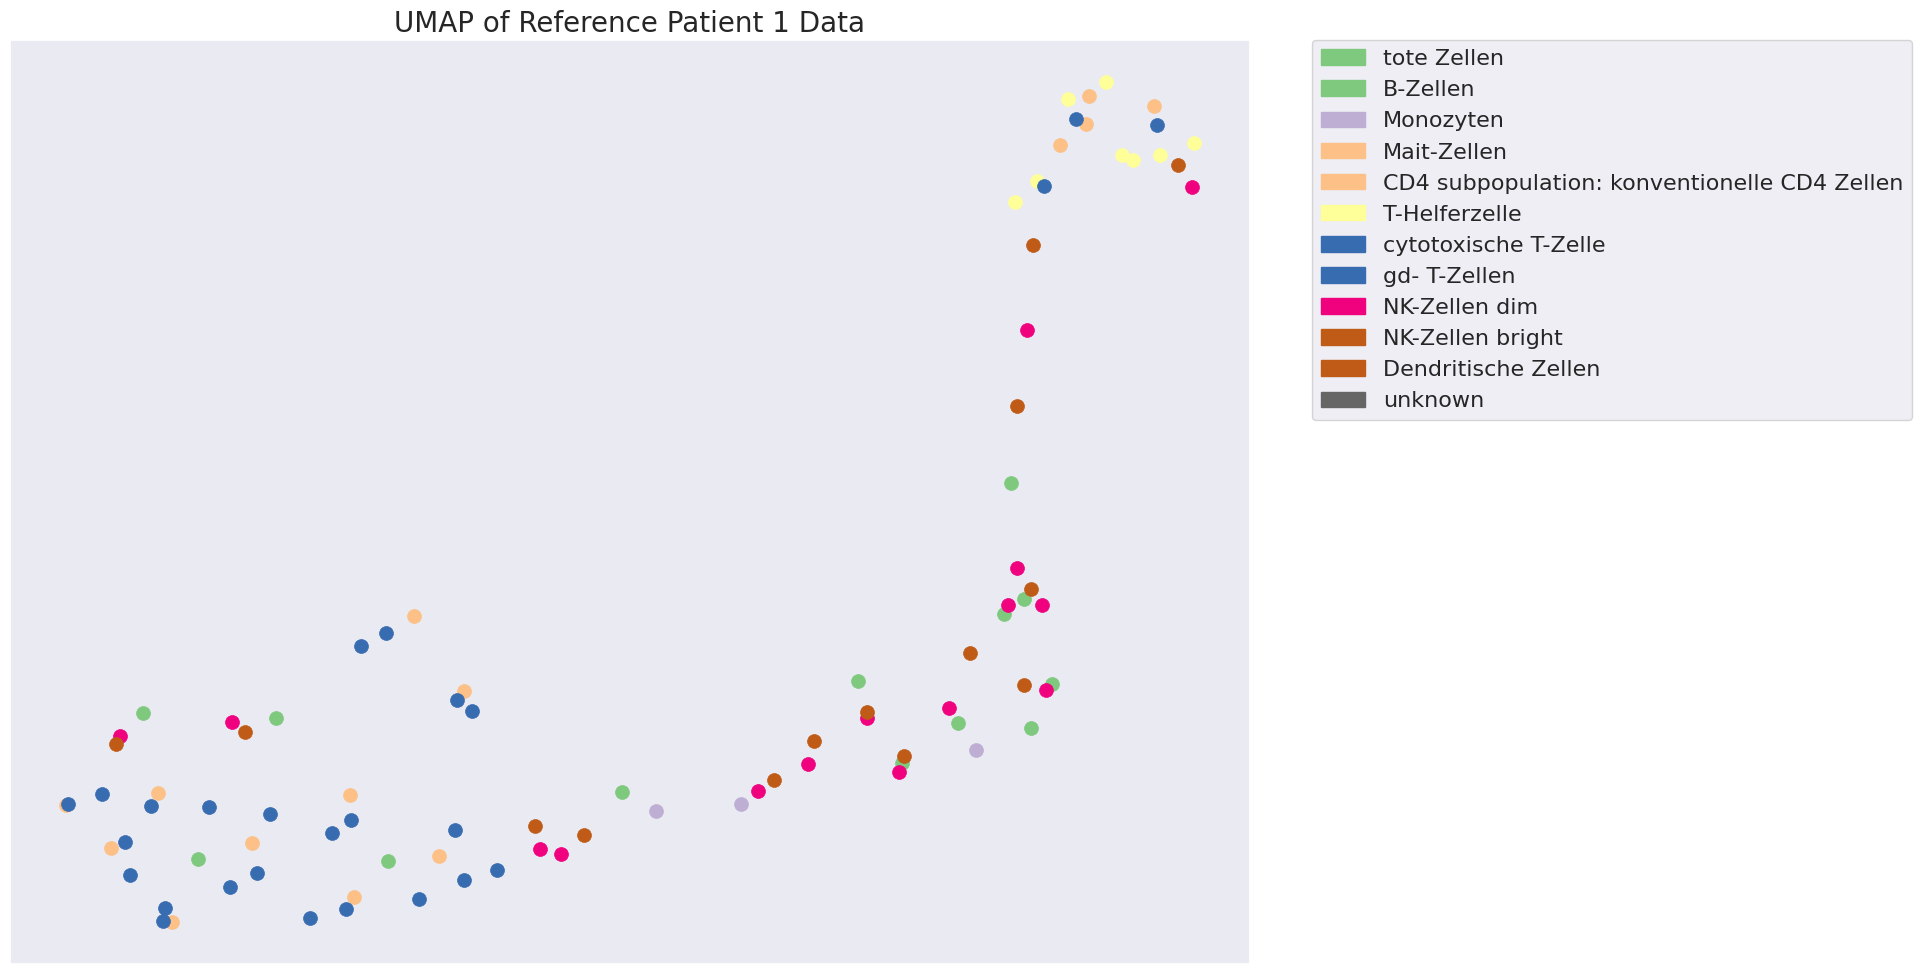

In [158]:
# UMAP transformation
umap_reducer = umap.UMAP(n_components=2, random_state=0)
Xre = umap_reducer.fit_transform(X_plot)  

# Plotting UMAP
cmap = cm.Accent 
fig = plt.figure(figsize=(16, 12))

for idx, key in enumerate(idx2ct):
    # Plot points belonging to each cell type
    indices = np.where(y_plot == key)[0]
    plt.plot(Xre[indices, 0], Xre[indices, 1], '.', color=cmap(idx / len(idx2ct)), alpha=0.6, label=key)

# Plot landmark points
for idx, key in enumerate(landmark_label):
    ax, ay = Xre[idx, 0], Xre[idx, 1]
    plt.plot(ax, ay, 'o', color=cmap(idx2ct.index(key) / len(idx2ct)), alpha=1, markersize=10, markeredgewidth=0.5)

# Add legend
plt.legend(handles=[mpatches.Patch(color=cmap(idx / len(idx2ct)), label=key) for idx, key in enumerate(idx2ct)],
           bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., prop={'size': 16})

plt.xticks([])
plt.yticks([])
plt.title("UMAP of Reference Patient 1 Data", fontsize=20)
plt.show()

The dataset is clustered or summarized based on marker models or predefined rules (phenograph, get_landmarks).
The raw data points are grouped and compared against these landmark summaries, which simplifies and abstracts the dataset.
UMAP is now applied to this combined dataset of landmarks and selected data points, which can emphasize clusters and reduce fine-grained variability seen in raw data.

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


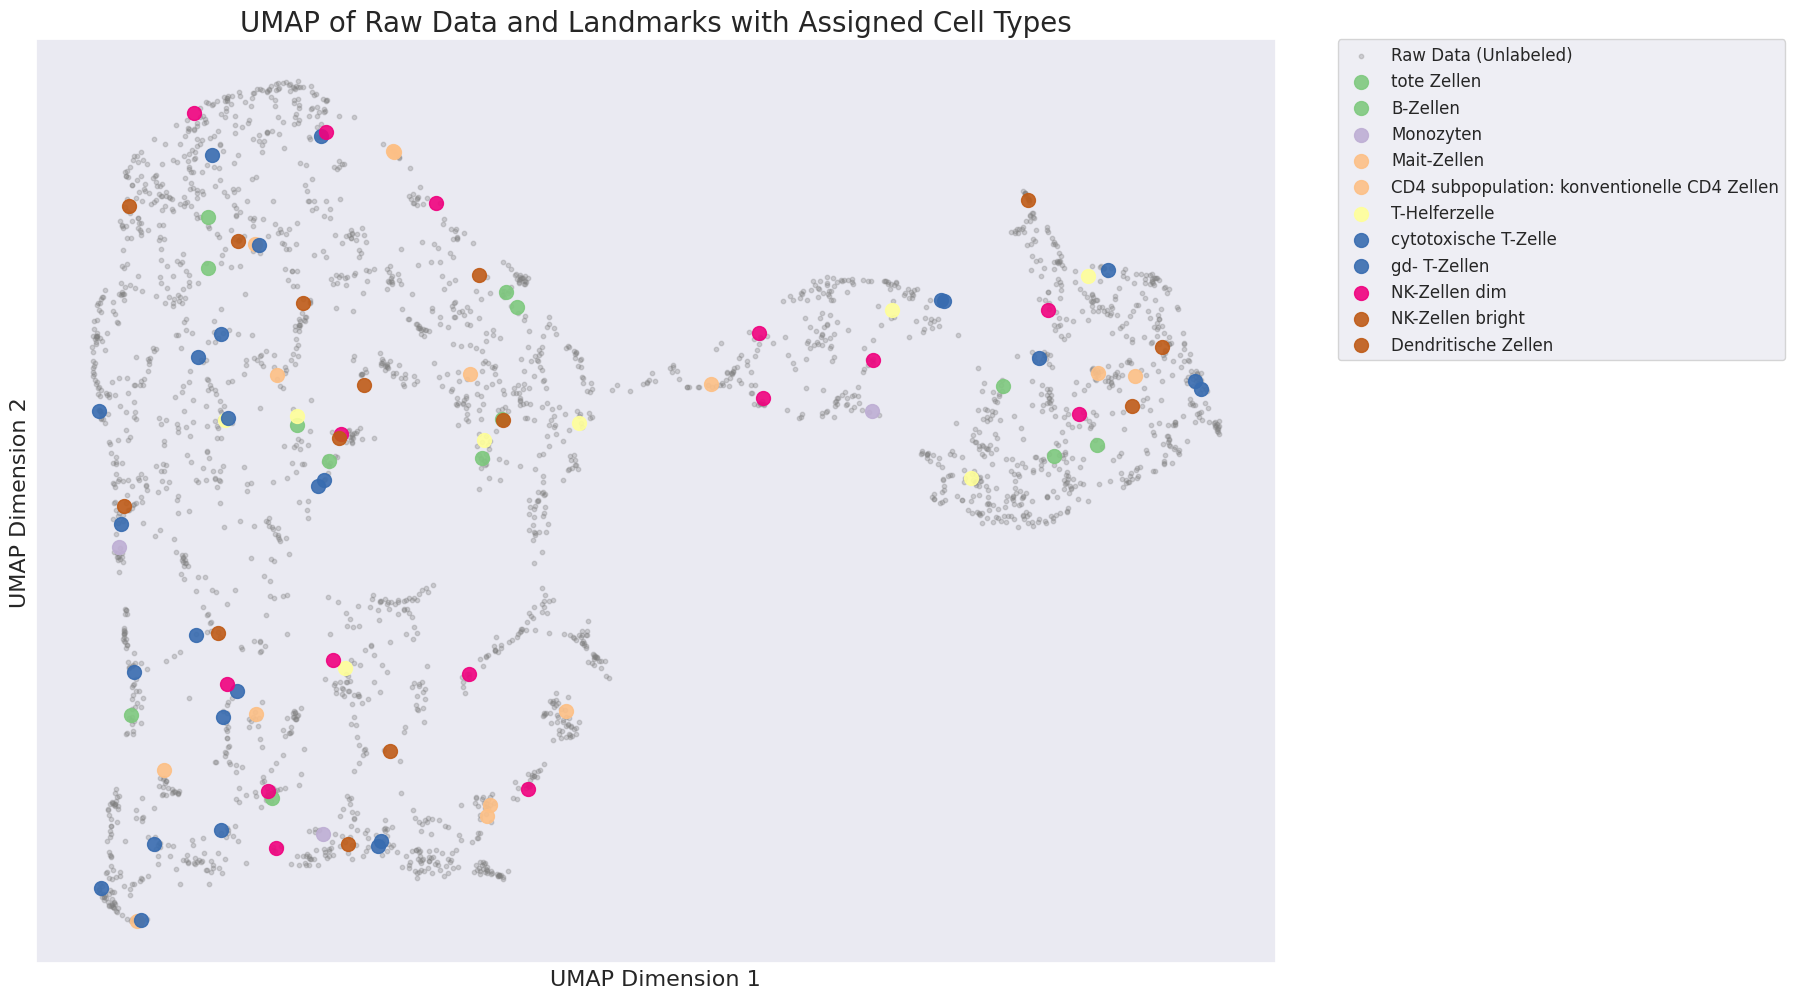

In [157]:
# Assuming necessary imports are already done:
# import numpy as np
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt
# from matplotlib import cm
# import umap

# Combine landmarks with full raw data
X_combined = np.vstack([landmark_mat, X0])  # Combine landmark data with the full raw dataset

# Create combined labels for UMAP visualization
# Assign "unknown" to raw data initially and use landmark_label for landmarks
y_combined = np.array(['unknown'] * X0.shape[0] + landmark_label)

# Perform UMAP on combined data
umap_reducer = umap.UMAP(n_components=2, random_state=0)
Xre_combined = umap_reducer.fit_transform(X_combined)  # UMAP transformation

# Plot UMAP with raw data and landmarks
cmap = cm.Accent  # Color map for different cell types
fig = plt.figure(figsize=(16, 12))

# Plot raw data points, labeled as "unknown"
indices_raw = np.where(y_combined == 'unknown')[0]  # Find indices of raw data
plt.scatter(
    Xre_combined[indices_raw, 0],
    Xre_combined[indices_raw, 1],
    s=10,
    c='gray',
    alpha=0.3,
    label='Raw Data (Unlabeled)'
)

# Plot landmarks, labeled by cell types
for idx, key in enumerate(idx2ct):
    if key != 'unknown':  # Skip "unknown" since raw data already plotted
        indices_landmark = np.where(y_combined == key)[0]  # Indices of this cell type
        plt.scatter(
            Xre_combined[indices_landmark, 0],
            Xre_combined[indices_landmark, 1],
            s=100,
            c=[cmap(idx / len(idx2ct))],
            alpha=0.9,
            label=key
        )

# Add legend for the cell types
plt.legend(
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    borderaxespad=0.,
    prop={'size': 12}
)

# Formatting
plt.xticks([])
plt.yticks([])
plt.title("UMAP of Raw Data and Landmarks with Assigned Cell Types", fontsize=20)
plt.xlabel("UMAP Dimension 1", fontsize=16)
plt.ylabel("UMAP Dimension 2", fontsize=16)
plt.show()

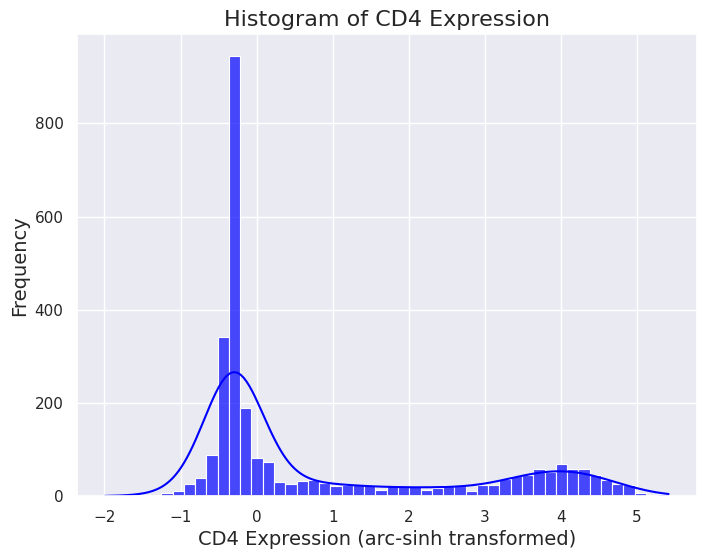

In [134]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select the specific marker
marker = "CD4"

# Plot the histogram for the marker
plt.figure(figsize=(8, 6))
sns.histplot(df[marker], bins=50, kde=True, color="blue", alpha=0.7)
plt.title(f"Histogram of {marker} Expression", fontsize=16)
plt.xlabel(f"{marker} Expression (arc-sinh transformed)", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.show()

In [153]:
# Step 1: Count the occurrences of each cell type, including 'unknown'
unknown_cells_count = cell_type_assignments.count('unknown')

# Step 2: Print the number of 'unknown' cells
print(f'Number of cells classified as "unknown": {unknown_cells_count}')

Number of cells classified as "unknown": 0


In [138]:
print(total_cells)

12093


Total cells: 93


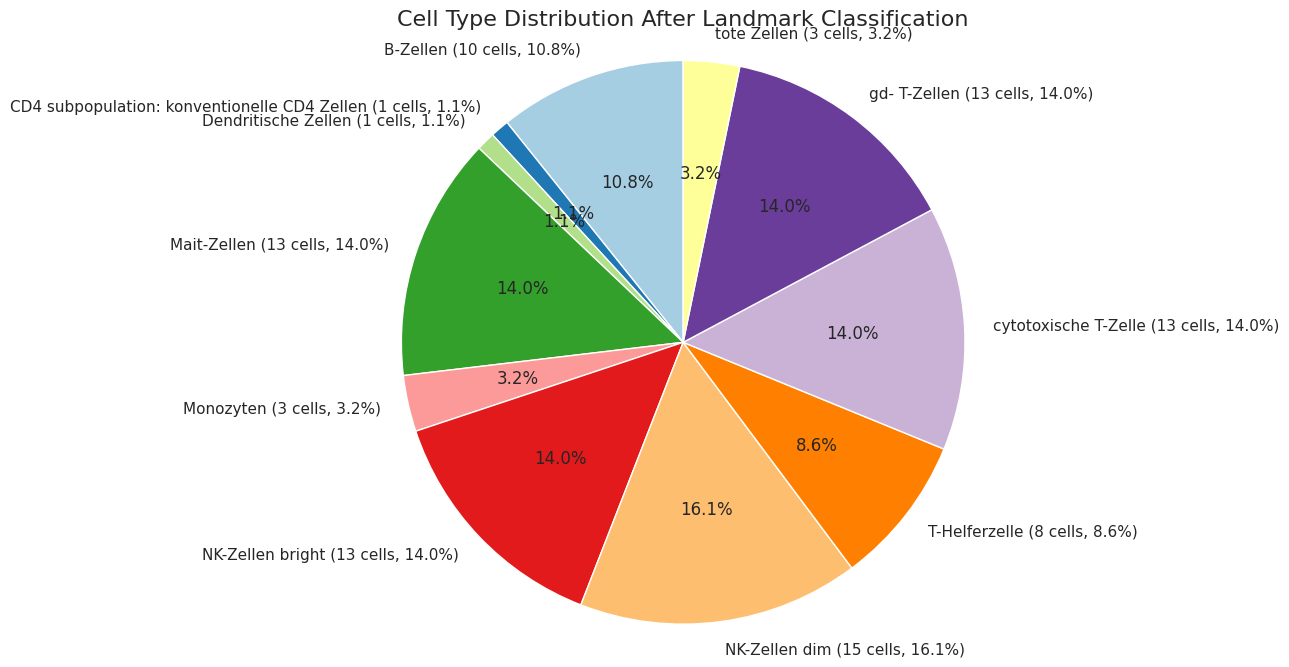

In [140]:
# Assuming you have a correct X0 and y_plot representation after landmark calculation
X_plot = landmark_mat.copy()  # Use landmark matrix as the base
y_plot = landmark_label[:]  # Copy the landmark labels to y_plot

# Assuming your classification of cell types is done via ACDC model.
# Replace this loop with logic that assigns each cell type correctly based on your scoring model
# Example: If you classify based on a score threshold or some logic in your marker model

# Let's assume y_plot is already populated with the correct labels from ACDC, so we don't duplicate data
# Make sure y_plot contains the same number of entries as your X0 (df)

# Now we can safely compute the pie chart
cell_type_counts = np.unique(y_plot, return_counts=True)

# Get the cell types (labels) and their counts
cell_types = cell_type_counts[0]
counts = cell_type_counts[1]

# Calculate percentages for each cell type
total_cells = np.sum(counts)
percentages = (counts / total_cells) * 100

# Ensure total_cells corresponds to the number of actual cells
print(f"Total cells: {total_cells}")

# Plotting the pie chart
fig, ax = plt.subplots(figsize=(8, 8))

# Create a pie chart
ax.pie(counts, labels=[f'{ct} ({int(count)} cells, {percent:.1f}%)' for ct, count, percent in zip(cell_types, counts, percentages)],
       autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)

# Equal aspect ratio ensures that pie chart is drawn as a circle.
ax.axis('equal')

plt.title('Cell Type Distribution After Landmark Classification', fontsize=16)
plt.show()


In [144]:
landmark_mat.shape

(93, 4)

In [145]:
df

,CD4,HLA-DR,CD14,CD3
0,4.571999,-0.267039,-0.303323,3.870162
1,4.949444,0.121515,-0.296808,3.982688
2,-0.273797,2.259889,-0.380829,-0.510464
3,3.129994,3.662323,-0.301931,3.822929
4,-0.505158,1.630940,-0.219461,1.710250
...,...,...,...,...
2833,0.547085,0.558763,1.531931,1.941639
2834,3.168043,-0.479684,-0.201484,0.219478
2835,4.277693,-0.108550,-0.302858,3.211577
2836,3.796714,0.328868,-0.365476,3.628073


Total cells: 2838


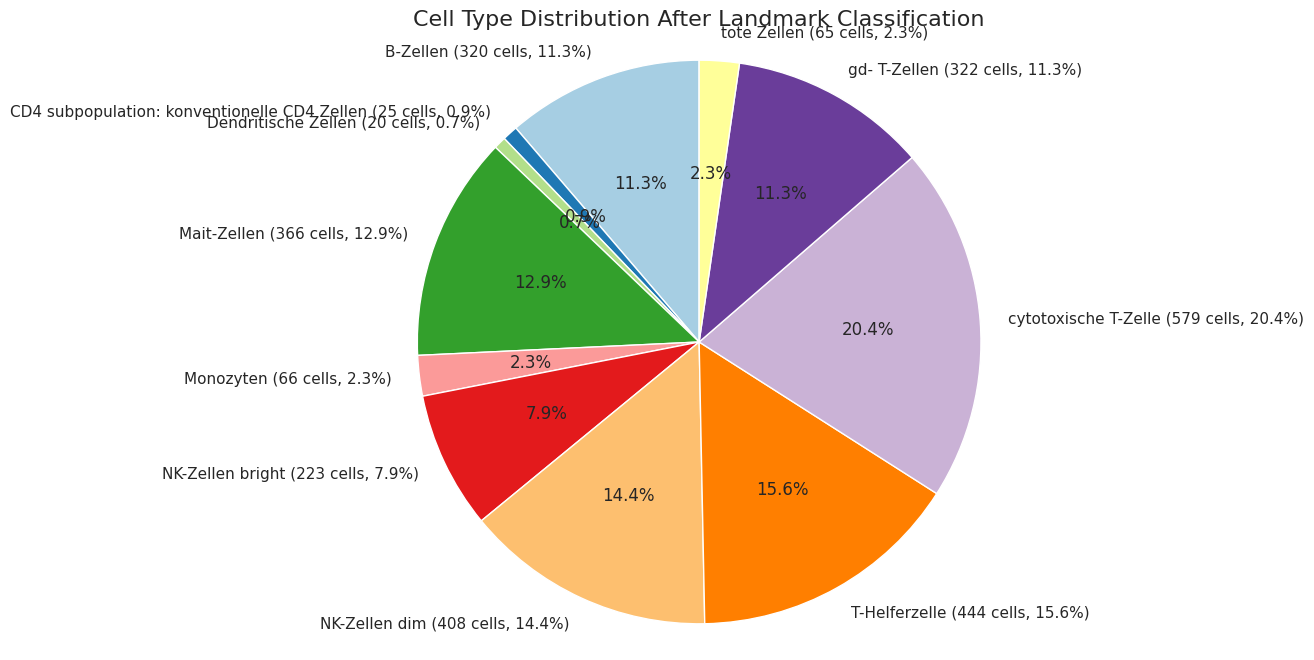

In [160]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming `X0` is your dataset of size (2838, 4)
# Assuming `landmark_mat` has shape (93, 4) and is used as a reference for landmark calculation

# `y_plot` should be populated with the cell type assignments for all 2838 cells
# If `landmark_label` is assigned based on landmark classification, we need to map those labels
# across all the cells in the dataset based on their proximity to the landmarks.

# Step 1: Assign cell types to all cells (this is a simplified approach for mapping to landmarks)
# For example, we might classify each cell in `X0` by finding the closest landmark (here we are using a simple example)
from sklearn.metrics.pairwise import euclidean_distances

# Compute pairwise distances between X0 (all cells) and landmark_mat (landmarks)
distances = euclidean_distances(X0, landmark_mat)

# Assign each cell to the closest landmark (in practice, this could be a more sophisticated model)
closest_landmarks = np.argmin(distances, axis=1)

# Step 2: Map the closest landmarks to the cell types
# Here we assume `landmark_label` corresponds to the cell types for the landmarks
cell_type_assignments = [landmark_label[i] for i in closest_landmarks]

# Step 3: Now create the pie chart
cell_type_counts = np.unique(cell_type_assignments, return_counts=True)

# Get the cell types (labels) and their counts
cell_types = cell_type_counts[0]
counts = cell_type_counts[1]

# Calculate percentages for each cell type
total_cells = np.sum(counts)
percentages = (counts / total_cells) * 100

# Ensure total_cells corresponds to the number of actual cells
print(f"Total cells: {total_cells}")

# Step 4: Plot the pie chart
fig, ax = plt.subplots(figsize=(8, 8))

# Create a pie chart with percentages
ax.pie(counts, labels=[f'{ct} ({int(count)} cells, {percent:.1f}%)' for ct, count, percent in zip(cell_types, counts, percentages)],
       autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)

# Equal aspect ratio ensures that pie chart is drawn as a circle.
ax.axis('equal')

plt.title('Cell Type Distribution After Landmark Classification', fontsize=16)
plt.show()

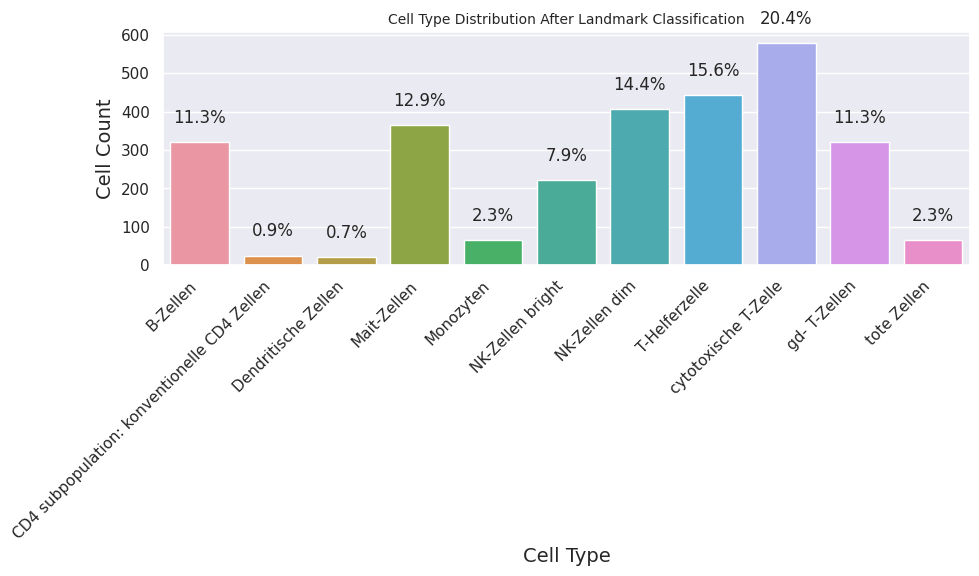

In [161]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import umap
from sklearn.metrics.pairwise import euclidean_distances

# Step 1: Assuming you have X0 (your dataset of 2838 cells) and landmark_mat (landmarks of 93 cells)
# And that you've already computed the closest landmarks and assigned cell types

# Assuming landmark_label contains the cell types corresponding to the landmarks
# and closest_landmarks are the indices of the nearest landmarks to each cell

# Create a mapping of cell type assignments
cell_type_assignments = [landmark_label[i] for i in closest_landmarks]

# Step 2: Barplot visualization

# Count occurrences of each cell type
cell_type_counts = np.unique(cell_type_assignments, return_counts=True)
cell_types = cell_type_counts[0]
counts = cell_type_counts[1]

# Calculate percentages
total_cells = np.sum(counts)
percentages = (counts / total_cells) * 100

# Plotting the barplot
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x=cell_types, y=counts, ax=ax)

# Add percentages on top of the bars
for i, count in enumerate(counts):
    ax.text(i, count + 50, f'{percentages[i]:.1f}%', ha='center', fontsize=12)

ax.set_title('Cell Type Distribution After Landmark Classification', fontsize=10)
ax.set_xlabel('Cell Type', fontsize=14)
ax.set_ylabel('Cell Count', fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


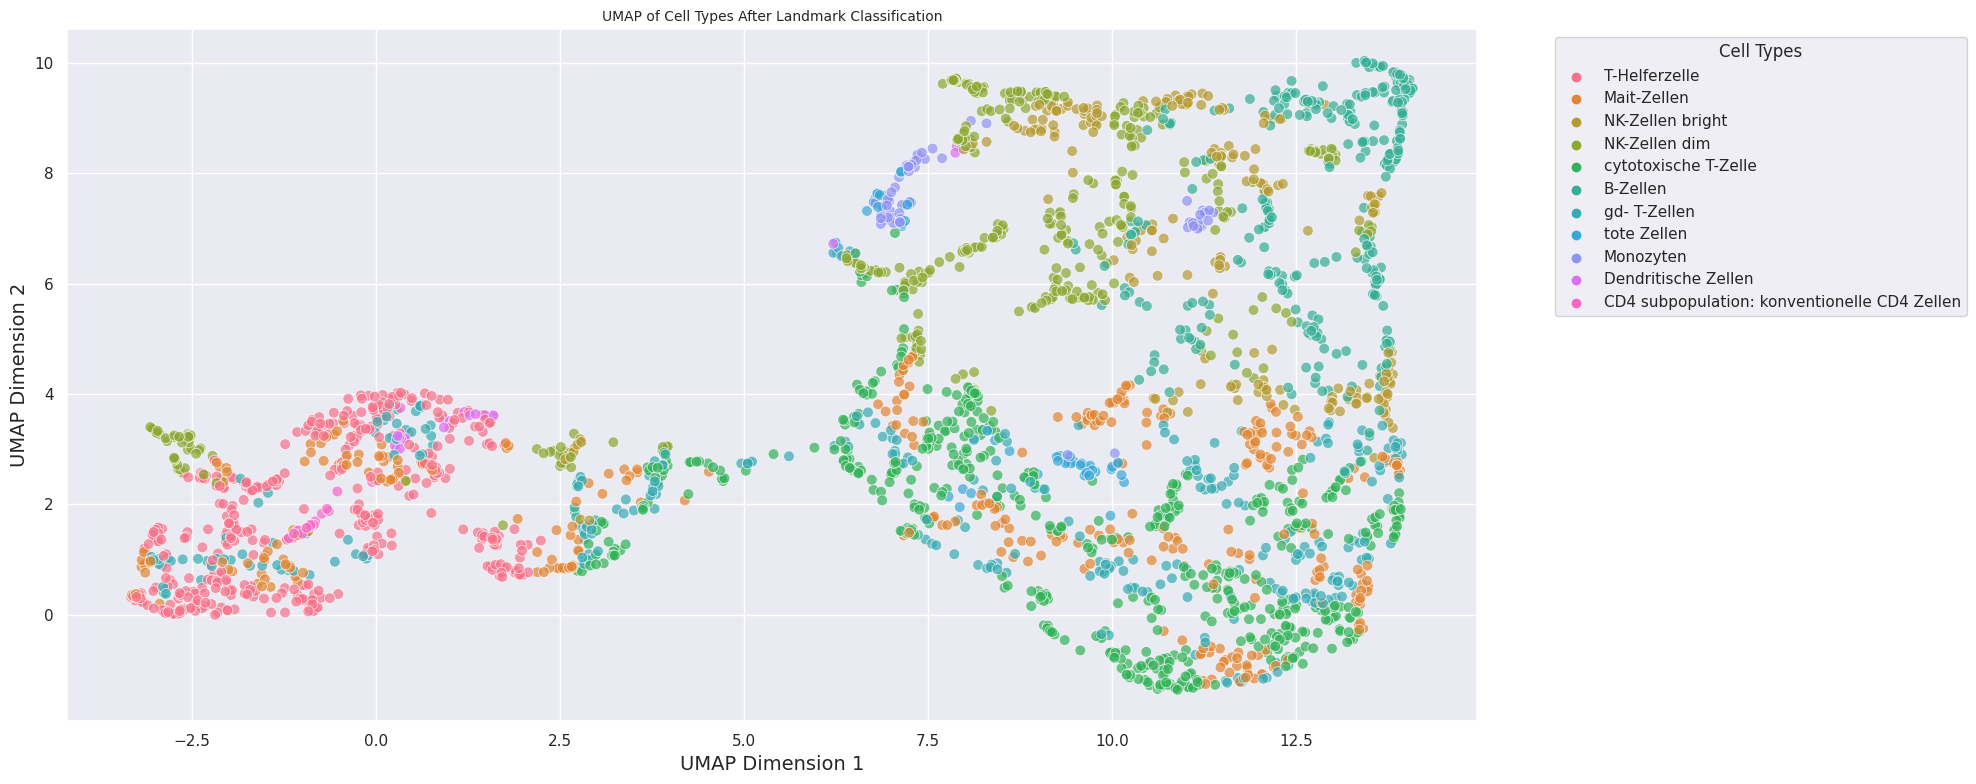

In [159]:
# Apply UMAP to reduce the dimensionality of your data (X0)
umap_reducer = umap.UMAP(n_components=2, random_state=42)
X_umap = umap_reducer.fit_transform(X0)

# Create a UMAP plot, colored by cell type assignments
fig, ax = plt.subplots(figsize=(20, 8))
sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=cell_type_assignments, ax=ax, s=60, alpha=0.7)

# Set plot title and labels
ax.set_title('UMAP of Cell Types After Landmark Classification', fontsize=10)
ax.set_xlabel('UMAP Dimension 1', fontsize=14)
ax.set_ylabel('UMAP Dimension 2', fontsize=14)
plt.legend(title='Cell Types', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()